## Chapter 3 – Image Classification Problem- Visual Learning- MNIST Dataset

Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélion Guéron (2017)

Following chapter 3 in book and https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

#### Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [5]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

#def save_fig(fig_id, tight_layout=True):
    #path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    #print("Saving figure", fig_id)
    #if tight_layout:
    #    plt.tight_layout()
    #plt.savefig(path, format='png', dpi=300)

### Load the data -- MNIST 
Warning: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [6]:
# Function to sort MNIST dataset
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [7]:
# Import the data set and sort it
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

# Look at the arrays
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [8]:
# Check the dimensions
mnist.data.shape

(70000, 784)

In [9]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [10]:
28*28

784

(-0.5, 27.5, 27.5, -0.5)

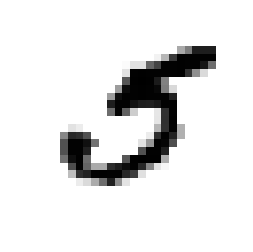

In [11]:
# 7000 images, each with 784 features (because each image is 28X28 pixels)
# Each feature represents one pixel's intensity

# To view one of the digits from the MNIST dataset you grab an instance's feature vector, reshape it to 
# a 28X28 array, and display it using the imshow() function from Matplotlib

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
#plt.show()

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


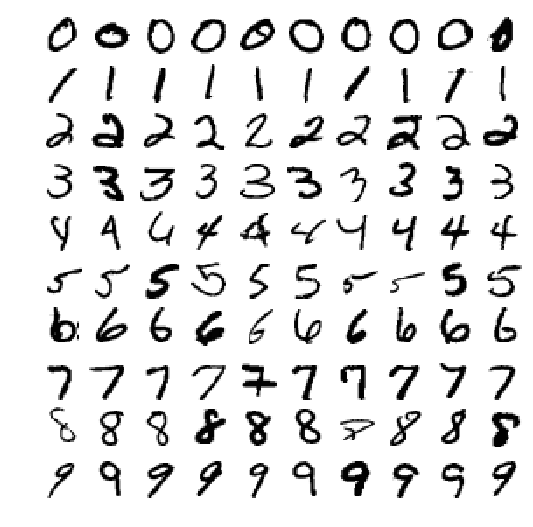

In [14]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

## Create Training and Test Sets

In [15]:
# Always do this before inspecting the data closely
# Also, shuffle* the training set to guarantee all cross-validation folds will be similar (you don't want any of 
# the folds to be missing one or more of the digits), also because some ML algorithms are sensitive to the order
# of training instances, and perform poorly if they get similar instances in a row.

# Create training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle training set
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# * For some data you do not want to shuffle randomly- e.g. time-series data 

## Train a Binary classifier

In [16]:
# Simplify the problem first and just train a classifier to identify one digit
# Train to classify "five" and "not five"

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Note: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly. This is why we set max_iter=5 and tol=-np.infty, to get the same results as in the book, while avoiding the warnings.

### Train classifier using stochastic gradient descent
Stochastic gradient descent is a good place to start: It is able to handle very large datasets efficiently.
This is partially because it deals with training instances independently, one at a time (which is also why SGD is good for online learning).
"stochastic"= random; SGD relies on randomness during training- so if you want reproducible results you need to set the random_state parameter.

In [17]:
# Create a stochastic gradient descent classifier and train it on the training set
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# Use it to detect images of the number 5
sgd_clf.predict([some_digit]) # We saved X[3600], which is a 5 as some_digit earlier,
# So now testing to see if the classifier identifies it as a 5, which we set above as the target classes (5/not 5)

array([ True])

## Evaluate the classifier using performance metrics

Evaluating a classifier can be more difficult than evaluating a regressor

### Measuring Accuracy using Cross-Validation

In [19]:
# If you need more precise control of cross-validation process than Scikit-Learn provides, you can implement it 
# "by-hand" and print the same result this way:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
    
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


#### StratifiedKFold class
The StratifiedKFold class performs stratified sampling to produce folds containing a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains the clone on the training folds, and makes predictions on the test fold. Then it will count the number of correct predictions and outputs the ratio of correct predictions


In [20]:
# Use cross_val_score() function to evaluate SGD Classifier model using K-fold cross-validation:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

95% accuracy
Even though this is not a very complex classifier, should take a look at the it before get too excited...

In [21]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

Because only about 10% of the images are 5s, if you always predict the image is not a 5 you will get 90% accuracy.
That is what has happened here.
And this is why Accuracy is not always the most effective or preferred performance metric, especially when you are dealing with skewed datasets (like this one, where 90% are not 5 and 10% are 5s.


A better performance metric is the confusin matrix, which gives you the numer of TP, FP, TN, and FN.
To do this you need to be able to compare predictions with the labeled (actual) target data. To do this use the cross_val_predict() function.

In [23]:
from sklearn.model_selection import cross_val_predict
# just like cross_val_score, ross_val_predict  performs K-fold cross-validation, but instead of returning the 
# scores it returns the predictions made on each test fold, so you get a clean prediction for each instance in the
# training set ("clean" = the prediction is made by a model that never saw the data during training.)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
# Now get the confusion matrix using the confusion_matrix() function by passing it the target classes
# and the predicted classes.
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [25]:
# TN, FP
# FN, TP

# Each row represents the *actual class*
# Each column represents the *predicted class*

# The first row of this confusion matrix considers the non-5 images (negative class): 53,272 TN, 1,307 FP
# The second row considers the 5 images (positive class): 1,077 FN (wrongly classifies as non-5, so were 
# classified as non-5 but were 5s), and 4,344 were correctly classified as non-5s (TP)

# A perfect classifier would only have TP and TN so that the confusion matrix would only have nonzero values across
# the diagonal
# e.g.:
# array([[54579, 0],
#        [    0, 5421]])

# Lots of info. from the confusion matrix, but more precise performance metrics are Precision and Recall

# Precision (accuracy of positive predictions) = TP/(TP+FP)
# Recall (A.K.A.: sensitivity or true positive rate (TPR) that is the ratio of positive instances that are 
# correctly detected by the classifier) = TP/(TP+FN)

In [26]:
# Ideal "perfect" predictions and the resultant confusion matrix

y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### Precision

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [28]:
# By-hand
4344 / (4344 + 1307)

0.7687135020350381

#### Recall

In [29]:
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [30]:
# By-hand
4344/(4344+1077)

0.801328168234643

These metrics demonstrate that the classifier is not really doing a good job.
When an image IS a 5, it is only classifying it correctly 77% of the time. (PRECISION)
Of all the images that are 5s, only 80% were predicted correctly. (RECALL)

Use the F-1 Score, which combines precision and recall into a single metric, and is helpful in providing a simple way of comparing two classifiers.

While the regular mean treats all values equally, this won't be as useful (to get the average of precision and recall) as the harmonic mean, which will give much more weight to low values and thus you will only get a high F1 score if both precision and recall are high, while the regular mean of both could still be high if at least one of them is high.

F1-Score equation:

=2/((1/precision) + (1/recall))

= 2*((precision * recall)/(precision + recall))

= TP/(TP + ((FN + FP)/2))

#### F1- Score

In [31]:
# Calculate the F-1 Score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

The F1-Score favors classifiers that have similar precision and recall. 

But this isn't always what you want depending on the problem (maybe FN are BAD). Sometimes you care more about precision, other times you care more about recall.

E.g., if you want to make sure FP are minimized you would prefer low recall and high precision; if you need to prioritize recall so that every possible instance of shoplifting, for example is caught even if it is a FP, you would want high recall and precision could be a lot lower. 

SGDClassifier computes a score based on a decision function. If that score is > the threshold, it assigns the instance to the positive class, otherwise it assigns the instance to the negative class. 

If you change the threshold then some of the instances will be assigned to a different class. 
If FP become TN then you increase prcision and therfore recall decreases. If a TP becomes a FN, then you decrase recall and increase precision.
Lowering the threshold increases recall and reduces precision in this example.

You cannot set the threshold directly in Scikit-Learn, but you can access the decision scores it uses to make predictions. Instead of calling the classifier's predict() method, you call its decision_function() method, which returns a score for each instance, and then you make predictions based on those scores using any theshold you want.

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([ True])

In [35]:
# The SGDCLassifier uses a threshold of 0 so it returns the same result as the predict() method

# Raise the threshold:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [36]:
# Raising the threshold decreases recall (because Y-scores > threshold = False)

In [36]:
# How to decide which threshold to use?

# To figure this out you need to get the socres of all instances in the training set using the cross_val_predict
# function, but this time specifying that you want it to return decision scores instead of predictions:

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

# Then with the predictions you compute precision and recall for all possible thresholds 
# using the precision_recall_curve() function.

Note: There was an issue in Scikit-Learn 0.19.0 (fixed in 0.19.1) where the result of cross_val_predict() was incorrect in the binary classification case when using method="decision_function", as in the code above. The resulting array had an extra first dimension full of 0s. Just in case you are using 0.19.0, we need to add this small hack to work around this issue:

In [37]:
y_scores.shape

(60000,)

In [38]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [39]:
# Then with the predictions you compute precision and recall for all possible thresholds 
# using the precision_recall_curve() function.

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

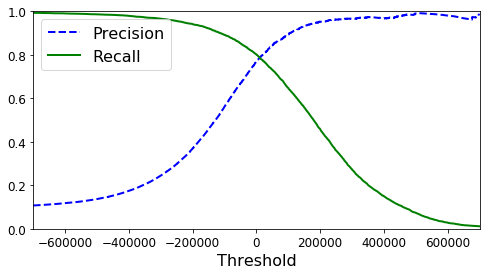

In [40]:
# And then plot precision and recall as functions of the threshold using MatplotLib:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

Why is the Precision curve bumpier than the recall curve?

While precision may sometimes go down when you raise the threshold (although in general it will go up).

When you start from a central threshold and move it just one digit to the right precision may go down, but recall can only go down when the threshold is increased, which is why the recall curve always looks smooth.

Once you plot out the P/R curve, select the threshold value that gives you the best precision/recall tradeoff for your task.

Another way to select a good P/R tradeoff is to plot precision directly against recall:

In [41]:
(y_train_pred == (y_scores > 0)).all()

True

In [42]:
# Decide to aim for 90% precision
# In the plot above it looks like the threshold will be about 70,000. To make predictions on the training set
# for now), instead of calling the classifier's predict() method you run the following code:

y_train_pred_90 = (y_scores > 70000) # You want to use y_scores -- y_scores = 
     # sgd_clf.decision_function([some_digit])--and set precision to > 70000 

In [43]:
precision_score(y_train_5, y_train_pred_90) # Close to 90% precision
#(but high precision isn't very useful if recall is low!)

0.8659205116491548

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

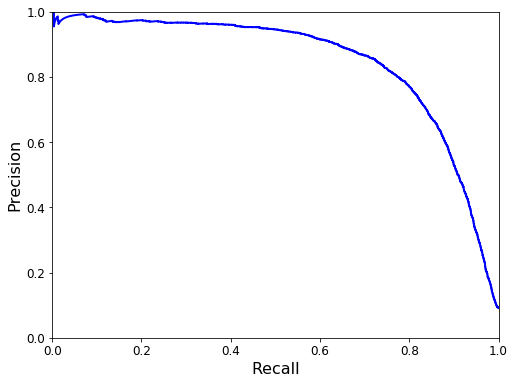

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

Precision starts to fall sharply after ~ 80% recall 
You probably want to select a P/R tradeoff just before the drop, at around 60% for example.

### ROC Curve 
Receiver Operator Characteristics Curve
Looking for the AUC (Area Under the Curve), the more, the better.

Instead of plotting precision vs. recall (A.K.A. specificity) it plots the recall (TP rate) against the FP rate.
The FPR is the ratio of negative instances that are incorrectly classified as positive and equals 1-TNR, which is the ratio of instances that are correctly classified as negative.

TNR = Specificity 

So, the ROC curve plots sensitivity (recall) versus 1-specificity.

To plot the ROC curve you first need to compute the TPR and FPR for various threshold values using the roc_curve() function.

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

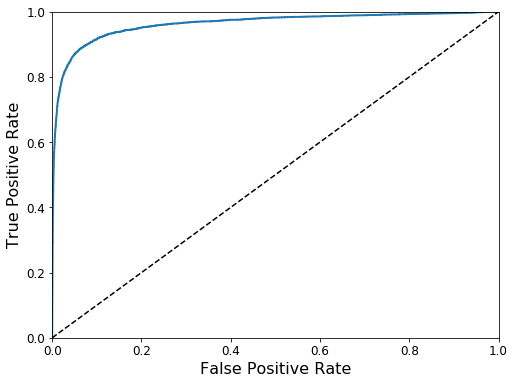

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

There is a tradeoff here too: The higher the recall (TPR), the more false positives (FPR) the classifier produces.

The dotted line= the the ROC curve of a purely random classifier. Thhis is a plot of a good classifier- it is near the top-left of the graph and as far away from the dotted-line as possible; near the top-right would be a bad classifier.

A way to compare classifiers is to measure the AUC (area under the curve) of an ROC curve.

A perfect classifier will have AUC=1 and a purely random calissifier will have an AUC=0.5.

Computer ROC AUC with Scikit-Learn:

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

Note: we set n_estimators=10 to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

The ROC curve is similar to the precision/recall (PR) curve, so how to decide which one to use?

The rule of thumb: Use PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.

Otherwise, use the ROC curve.

Example: The ROC curve and ROC AUC scores above imply that the classifier is really good. However, this is mostly as result of there being only a few positive examples (5s) compared to the negatives (not 5s) in the training set. Unlike the ROC curve, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

### Train a RF classifier and compare its ROC curve and ROC AUC score to the SGD classifier

To do this you need to get scores for each instance in the training set. However, the RF classifier doesn't have a decision_function() method. Instead it has a dict_proba() method. Scikit-Learn classifiers generally have one or the other. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance the image represents a 5).

In [49]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

But to plot a ROC curve you need scores, not probabilities. To get these scores you can use the positive class's probability as the score.

In [50]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

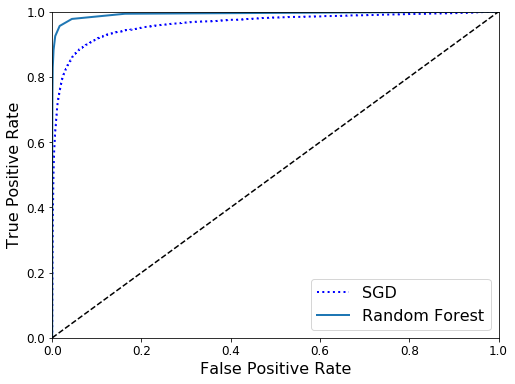

In [51]:
# Plot the first (SGD Classifier) curve also to compare it to the RF Classifier.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

The RF Classifier performed better.

The ROC AUC score is also significantly better.

In [53]:
# Measure the precision and recall scores for the RF Classifier too:

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

## Multiclass Classification

RF and naive Bayes classifiers, for example, can handle multiclass classification problems directly. Others like SVM and Linear classifiers are strictly binary classifiers, but there are strategies you can use to perform multiclass classification using multiple binary classifiers for these.

One-Versus-All strategy:

E.g., to create a system that can classify the digit images into 10 classes (0 to 9) you can train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, etc.). THen when you want to classify an image, you get a decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is the One-Versus_All (OvA) strategy, A.K.A. one-versus-the-rest.

One-Versus-One (OvO) Strategy:

Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, andother for 1s and 2s, and so on. If there are N classes, you need to train N*(N-1)/2 classifiers. For the MNIST problem you'd have to train 45 classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class "wins the most duels". The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms, like SVM classifiers, scale poorly with the size of the training set, and so OvO is preferred since it is faster to train many classifiers on small training sets than train few classifiers on large training sets. *For most binary classification problems, however, OvA is preferred.*

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers, for which it uses OvO).

Try this with the SGD Classifier:

In [55]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [56]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores #returns a score for each class since 10 classes this time

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [57]:
np.argmax(some_digit_scores) # The highest score is the one corresponding to digit 5.

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g. index 0 is 0 and 5 is 5). It usually doesn't work this way.



To force Scikit-Learn to use OvA or OvO, you can use the OneVsOneClassifier or OneVsRestClassifier classes. You just create an instance and pass a binary classifier to its constructor.

E.g., the following code creates a multiclass classifier using the OvO strategy, based on the SGD Classifier:

In [58]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [59]:
len(ovo_clf.estimators_) #Length should be 45 bc N*(N-1)/2=10*(10-1)/2=45

45

#### Train a Random Forest Classifier

This time, Scikit-Learn doesn't have to run OvO or OvA because RF classifiers can directly classify instances into multiple classes. You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class.

In [60]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [61]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

The classifier is pretty confident about its prediction: the 0.8 at the 5th index in the array means that the model estimates an 80% probability that the image represents a 5. But it also thinks the image could be a 0 or a 3 (10% chance each).

Now evaluate these classifiers using cross-validation.

In [62]:
#First evaluate the SGDClassifier's accuracy using cross_val_score() function
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

If you used a purely random classifier, you'd get a score of 10% accuracy (because 10 classes), so the score of 84% on all test folds is good, but you can still do much better- e.g., simply scaling the inputs increases accuracy above 90%:

In [65]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

Accuracy is 90% on all test folds after scaling.

## Error Analysis

Assume here you found a promising model and you want to find ways to improve it:
(If you haven't yet found a promising model you'd need to explore data preparation options, try out more models, shortlist the best ones, and fine-tune their hyperparameters using GridSearchCV, and automating as much as possible in a pipeline.)

Since you found a promising model you need to do some error analysis.

First look at the confusion matrix. Need to make predictions using the cross_val_predict() function and then call the confusion_matrix() function:

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [68]:
# Lots of numbers, so it will be easier to look at an image representation of the confusion matrix in this case:

def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

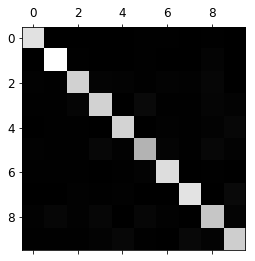

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Overall, the confusion matrix looks good, since most images are on the main diagonal, meaning that they were classified correctly. The 5s look slightly darker than the other digits. This could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as it does on the other digits. You can verify that both are in fact the case:

Focus the plot on errors. To do this you need to first divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error *rates* instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now fill the diagonal with zeros to keep only those errors and plot the result:

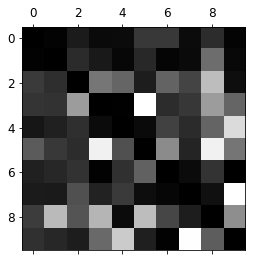

In [71]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
#save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Remember: The rows represent the actual classes, and the columns represent the predicted classes. The columns for classes 8s and 9s are pretty bright overall- this tells you that 8s and 9s are often confused with other digits. On the other hand, some of the rows like 1 class is pretty dark, which means that most 1s are classified correctly (except a few are confused with 8s as is clear because row 1, column 8 is lighter. Notice that the errors aren't perfectly symmetrical, for example more 5s are misclassified as 8s compared to rate that 8s are misclassified as 5s.

Confusion matrix analysis can provide insights on how to improve a classifier. This plot demonstrates that we should spend some time on the classification of 8s and 9s, and fixing the 3/5 confusion (the two lightest squares in the matrix).

How to do this?

Some options: 

* Try getting more training data for these digits.
* Engineer new features that would help the classifier, e.g., writing an algorithm to count the number of closed loops (e.g. 8 has two, 0, 6, and 9 have one each, and 1, 7, and 5 each have none).
* Preprocess the images (using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also help you gain insight on what you classifier is doing and why it is failing, but this is more difficult and time-consuming. For example, plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib's imshow() function).

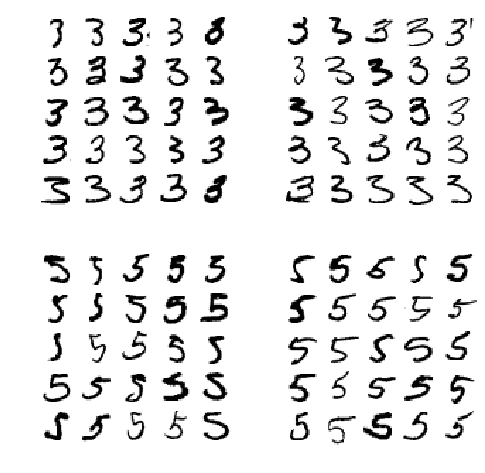

In [72]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

The two 5X5 blocks on the left show digits classified as 3s, the two on the right show digits classified as 5s. Some of the digits the classifier gets wrong (i.e., in the bottom-left and top-right blocks are so badly written that even a human would have trouble classifying them!

However, most misclassified images seem like obvious errors to us, and it is difficult to understand why the classifier made the mistakes it did.

The reason is that we used a simple SGD Classifier, which is a linear model. All this does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ by only a few pixels, the model will easily confuse them.

The main difference between 3s and 5s is the position of the small line joining the top to the bottom arc. If you draw a 3 with the junciton shifted slightly to the left, the classifier might classify it asa a 5 and vice versa. This classifier is sensitive to image shifting and rotation. So one way to reduce the 3/5 image confusion would be to preprocess the images to ensure they are all well-centered and not rotated too much. This would probably reduce other errors too.

## Multilabel Classification

Will output multiple classes for each instance. KNeighbors classifier supports multilabel classification, not all classifiers do.

In [73]:
# Training a multilabel classifier to output whether the target is large (>=7) and whether it is odd.
# For 5, it should be F and T.
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [74]:
knn_clf.predict([some_digit])

array([[False,  True]])

Warning: the following cell may take a very long time (possibly hours depending on your hardware).

In [79]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

## Multioutput classification

Multioutput multiclass classification, A.K.A. multioutput classification. It is a generalization of multilabel classification where each label can be multiclass- have more than two possible values.

Multioutput systems are not limited to classification tasks; you can also have a system that outputs multiple labels per instance, including both class labels and value labels.

To illustrate this build a system that removes noise from images. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). Therefore it is an example of a multioutput classification system.

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
# We are checking out an image from the test set, this is frowned upon, 
# but we are doing it for illustrative purposes!

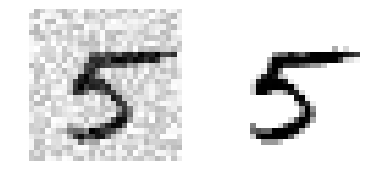

In [77]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

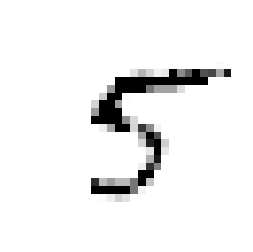

In [78]:
# Train the classifier and make it clean this image (on the left)
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
# save_fig("cleaned_digit_example_plot")

## Extra material
## Dummy (ie. random) classifier

In [80]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

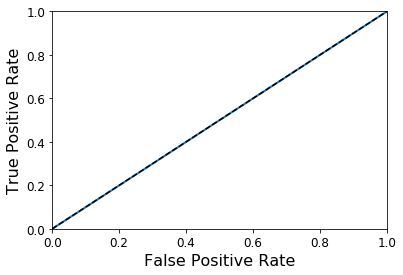

In [81]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [82]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4) #n_jobs=-1 means run as many jobs as you can
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [83]:
y_knn_pred = knn_clf.predict(X_test)

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

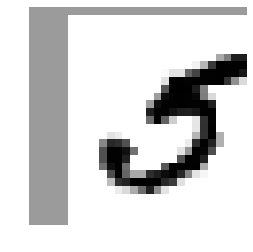

In [85]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))  

In [86]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [87]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [88]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [89]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [90]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

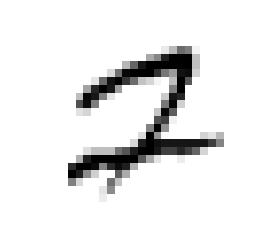

In [91]:
plot_digit(ambiguous_digit)

### Exercise solutions
1. An MNIST Classifier With Over 97% Accuracy

Warning: the next cell may take hours to run, depending on your hardware.

In [99]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 631.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [100]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [101]:
grid_search.best_score_

0.97325

In [102]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### 2. Data Augmentation

In [92]:
from scipy.ndimage.interpolation import shift

In [93]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

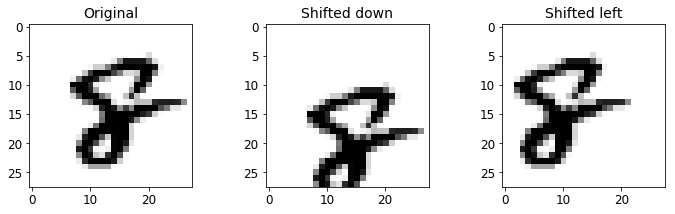

In [94]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [95]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [96]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [103]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [104]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

WARNING: The following cell may also take a while.

In [105]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got a 0.5% accuracy boost.

(Compared to the accuracy score we got for non-augmented knn_clf of 0.9714.)